# 22.RNN의 기초를 실습해 봅시다.

* SK주식회사의 일별 주가 데이터를 이용하여 RNN 모델을 구현해 봅시다.

## 1.환경 및 데이터 준비

### Import Packages

In [53]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras

In [54]:
# 필요한 함수 만들기
from sklearn.metrics import mean_squared_error

def mse_real(y_test, y_pred, max, min, squared = 1):
    # 실제값 변환 
    y_test_r = y_test * (max - min) + min
    y_pred_r = y_pred * (max - min) + min
    if squared == 1 :
        return(mean_squared_error(y_test_r, y_pred_r))
    else :    
        return(mean_squared_error(y_test_r, y_pred_r, squared = False))

### Data Loading

데이터를 불러와서 간단한 전처리를 수행합니다. 

In [55]:
stock = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/SK.csv')
dow = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/DowJonesIndex.csv')

stock.Date = pd.to_datetime(stock.Date)  
dow.Date = pd.to_datetime(dow.Date)      
dow.columns = ['Date', 'dow_Close']
stock = pd.merge(stock, dow, how = 'left')
stock = stock[stock['Date'] < "2019-10-01"]
stock =  stock.fillna(method = 'ffill')
stock.head()

,Date,Open,High,Low,Close,AdjClose,Volume,dow_Close
0,2016-01-04,243000.0,245000.0,234500.0,234500.0,226585.6563,173905.0,17148.93945
1,2016-01-05,236000.0,244000.0,234000.0,241000.0,232866.2813,182985.0,17158.66016
2,2016-01-06,241000.0,243000.0,237500.0,239000.0,230933.7813,108574.0,16906.50977
3,2016-01-07,237000.0,243000.0,236000.0,240500.0,232383.1563,113376.0,16514.09961
4,2016-01-08,240500.0,242500.0,235000.0,241500.0,233349.4063,81557.0,16346.45020


* Open : 장 시작 주가
* High : 장 중 최고가
* Low : 장 중 최저가
* Close : 장 마감 주가(종가)
* AdjClose : 수정된 종가(사용하지 않습니다.)
* Volume : 거래량

## 2.데이터 이해

### 탐색하기

주가의 흐름을 살짝 살펴봅시다.

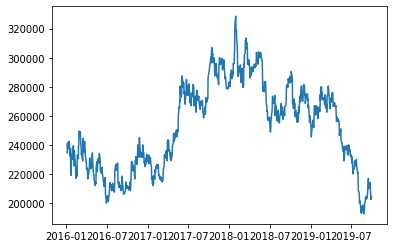

In [56]:
plt.plot(stock.Date, stock.Close)
plt.show()

## 3.데이터 준비

### 불필요한 데이터 정리 

In [57]:
stock = stock.drop(['Date','AdjClose'], axis=1)
stock.head()

,Open,High,Low,Close,Volume,dow_Close
0,243000.0,245000.0,234500.0,234500.0,173905.0,17148.93945
1,236000.0,244000.0,234000.0,241000.0,182985.0,17158.66016
2,241000.0,243000.0,237500.0,239000.0,108574.0,16906.50977
3,237000.0,243000.0,236000.0,240500.0,113376.0,16514.09961
4,240500.0,242500.0,235000.0,241500.0,81557.0,16346.45020


### Scaling



In [58]:
# 필요한 함수 로딩
from sklearn.preprocessing import MinMaxScaler

# 함수 선언
scaler = MinMaxScaler()

# 함수 적용하기
data = scaler.fit_transform(stock)

In [59]:
data[:5]

array([[0.36231884, 0.36996337, 0.34339623, 0.30882353, 0.1180101 ,
        0.12725551],
       [0.3115942 , 0.36263736, 0.33962264, 0.35661765, 0.1241717 ,
        0.12808642],
       [0.34782609, 0.35531136, 0.36603774, 0.34191176, 0.07367717,
        0.10653322],
       [0.31884058, 0.35531136, 0.35471698, 0.35294118, 0.07693576,
        0.07299097],
       [0.3442029 , 0.35164835, 0.34716981, 0.36029412, 0.05534372,
        0.05866071]])

## 4.Sequence 데이터 구조로 만들기

### 과제1 : 데이터 구조 만들기

In [24]:
data.shape

(915, 6)

In [28]:
timestep = 20

# X는 3차원으로 만들어 줘야 합니다. Close의 열 인덱스는 3입니다.
x = np.array([data[i : i + timestep, 3:4 ] for i in range(len(data) - timestep)])
y = np.array([data[ i + timestep, 3:4 ] for i in range(len(data) - timestep)])

# train = 0:700, val = 700:800, test = 800:
x_train, x_val, x_test =  x[:700], x[700:800], x[800:]
y_train, y_val, y_test =  y[:700], y[700:800], y[800:]

print(x.shape, y.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(895, 20, 1) (895, 1)
-------------------------------
(700, 20, 1) (700, 1)
(100, 20, 1) (100, 1)
(95, 20, 1) (95, 1)


## 5.모델링

### 과제2 : 선형 모델 만들기

In [16]:
# # 세션클리어
keras.backend.clear_session()

# Sequential 모델 선언+ 레이어 추가 하기
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(4, input_shape=[20, 1]) )
model.add(keras.layers.Dense(1, activation='tanh'))

# compile
model.compile(loss='mse', optimizer='adam')

# 학습
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30


ValueError: ignored

In [ ]:
# 학습 곡선을 그려봅시다.
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
# 예측


# 실제값으로 평가하기
mse_real(     )


결과의 의미는?

### (옵션) 위 선형 모델을 Neural Net 모델(히든레이어 추가)로 만들어 봅시다.

### 과제3 : Simple RNN 모델 만들기

다음을 조절하며 최적의 성능을 얻기 위한 모델을 만들어 봅시다!
* RNN Layer Note수

In [ ]:
# # 세션클리어


# Sequential 모델 선언+레이어 추가 하기


# compile


# 학습



In [ ]:
# 학습 곡선을 그려봅시다.



In [ ]:
# 예측


# 실제값으로 평가하기
mse_real(     )


### 과제4 : Deep RNN 모델 만들기

다음을 조절하며 최적의 성능을 얻기 위한 모델을 만들어 봅시다!
* RNN Layer 수
* RNN Layer Note수
* Learning Rate

In [ ]:
# # 세션클리어


# Sequential 모델 선언+추가 하기


# compile


# 학습



In [ ]:
# 학습 곡선을 그려봅시다.



In [ ]:
# 예측


# 실제값으로 평가하기
mse_real(     )


### 과제5 : LSTM 모델 만들기

다음을 조절하며 최적의 성능을 얻기 위한 모델을 만들어 봅시다!
* LSTM Layer 수
* LSTM Layer Note수
* Learning Rate

In [ ]:
# # 세션클리어


# Sequential 모델 선언+추가 하기


# compile


# 학습



In [ ]:
# 학습 곡선을 그려봅시다.



In [ ]:
# 예측


# 실제값으로 평가하기
mse_real(     )


### 과제6 : GRU 모델 만들기

다음을 조절하며 최적의 성능을 얻기 위한 모델을 만들어 봅시다!
* GRU Layer 수
* GRU Layer Note수
* Learning Rate

In [50]:
# # 세션클리어
keras.backend.clear_session()

# Sequential 모델 선언+ 레이어 추가 하기
model = keras.models.Sequential([ 
    keras.layers.GRU(32, input_shape = [20,1], return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(1)
])

# compile
model.compile(loss = 'mse', optimizer= keras.optimizers.Adam(lr=0.005))

# 학습
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))


Epoch 1/30
22/22 [==============================] - 5s 70ms/step - loss: 0.0704 - val_loss: 0.0041
Epoch 2/30
22/22 [==============================] - 0s 21ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 3/30
22/22 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/30
22/22 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 9.0761e-04
Epoch 5/30
22/22 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 9.6101e-04
Epoch 6/30
22/22 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 8.0563e-04
Epoch 7/30
22/22 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 7.9671e-04
Epoch 8/30
22/22 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 7.8560e-04
Epoch 9/30
22/22 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 7.7478e-04
Epoch 10/30
22/22 [==============================] - 0s 21ms/step - loss: 9.4852e-04 

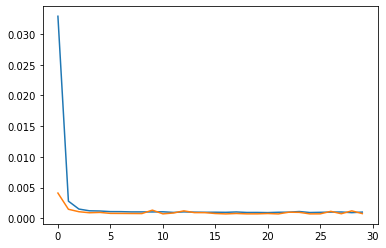

In [51]:
# 학습 곡선을 그려봅시다.
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [52]:
# 예측
pred = model.predict(x_test)

# 실제값으로 평가하기
mse_real(y_test, pred, scaler.data_max_[0], scaler.data_min_[0], squared=0 )


3779.741113398312

## (Optional)숙제
아래 숙제를 수행한 후 강사에게 메일로 숙제를 제출하는 분께는 소정의 선물을 드립니다~!

* 지금까지 실습은 종가(Close) 하나의 feature만 가지고, 수행해 본 결과입니다.
* 본 과제는
    * 나머지 모든 Feature를 다 사용해서
    * Deep RNN, LSTM, GRU 모델을 각각 만들고 성능을 비교하시오.

In [98]:
a = [1,2,3,4,5,6]
a[2:3+5:6]

[3]

In [101]:
timestep = 20

y = np.array([data[ i + timestep, 3:4 ] for i in range(len(data) - timestep)])
y.drop(['Close'])
x = np.array([data[i : i + timestep, 1:4 ] for i in range(len(data) - timestep)])
y = np.array([data[ i + timestep, 3:4 ] for i in range(len(data) - timestep)])

x_train, x_val, x_test =  x[:700], x[700:800], x[800:]
y_train, y_val, y_test =  y[:700], y[700:800], y[800:]

print(x.shape, y.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(895, 20, 3) (895, 1)
-------------------------------
(700, 20, 3) (700, 1)
(100, 20, 3) (100, 1)
(95, 20, 3) (95, 1)


In [94]:
### Deep RNN ###

keras.backend.clear_session()

model = keras.models.Sequential([ 
    keras.layers.SimpleRNN(20, input_shape = [20,5], return_sequences=True),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss = 'mse', optimizer= keras.optimizers.Adam(lr=0.005))

history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30


ValueError: ignored

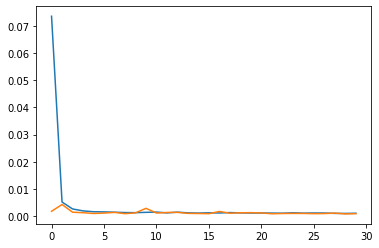

In [70]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [71]:
pred = model.predict(x_test)
mse_real(y_test, pred, scaler.data_max_[0], scaler.data_min_[0], squared=0 )

4249.527101189164

In [ ]:
### RSTM ###

In [72]:
keras.backend.clear_session()

model = keras.models.Sequential([ 
    keras.layers.LSTM(20, input_shape = [20,4], return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model.compile(loss = 'mse', optimizer= keras.optimizers.Adam(lr=0.05))

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
22/22 [==============================] - 4s 52ms/step - loss: 0.8006 - val_loss: 0.0025
Epoch 2/20
22/22 [==============================] - 0s 17ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 3/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 5/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 6/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 7/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 9/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 10/20
22/22 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 11/

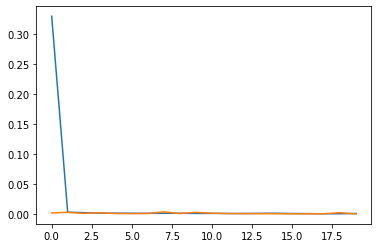

In [73]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [74]:
pred = model.predict(x_test)
mse_real(y_test, pred, scaler.data_max_[0], scaler.data_min_[0], squared=0 )

3650.614721569654

In [65]:
### GRU ###

In [90]:
keras.backend.clear_session()

model = keras.models.Sequential([ 
    keras.layers.GRU(32, input_shape = [20,4], return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(1)
])

model.compile(loss = 'mse', optimizer= keras.optimizers.Adam(lr=0.005))

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
22/22 [==============================] - 5s 84ms/step - loss: 0.0476 - val_loss: 0.0056
Epoch 2/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 3/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0015 - val_loss: 9.6444e-04
Epoch 4/20
22/22 [==============================] - 1s 25ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/20
22/22 [==============================] - 1s 25ms/step - loss: 0.0012 - val_loss: 9.7554e-04
Epoch 6/20
22/22 [==============================] - 1s 28ms/step - loss: 0.0010 - val_loss: 8.5374e-04
Epoch 7/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0012 - val_loss: 8.5877e-04
Epoch 8/20
22/22 [==============================] - 1s 23ms/step - loss: 0.0010 - val_loss: 9.9383e-04
Epoch 9/20
22/22 [==============================] - 1s 25ms/step - loss: 0.0010 - val_loss: 9.8872e-04
Epoch 10/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0011 - va

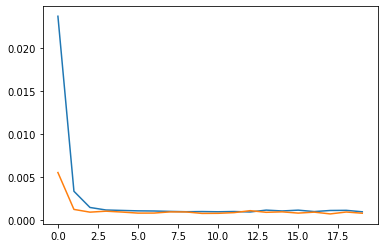

In [91]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [92]:
pred = model.predict(x_test)
mse_real(y_test, pred, scaler.data_max_[0], scaler.data_min_[0], squared=0 )

3578.4220993359527